In [20]:
from river import stream
from tqdm import tqdm
import time

import pbt
import wabt
from wabt import WeightAdjustingBinaryTransformation
from utils import get_dataset, compute_metrics_dataset_online
import nemenyi
import numpy as np
from river import multioutput
from river import tree
import importlib

In [21]:
importlib.reload(wabt)

<module 'wabt' from 'C:\\Users\\yago\\Desktop\\Yagiz\\CS Development\\Data Veracity\\wabt.py'>

In [22]:
# For verifying that the datasets can be loaded:
n_labels, X, Y = get_dataset('Reuters.arff')
print(X[0])
print(Y[0])
print(n_labels)

[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.07601

In [23]:
def add_feature_noise(x, noise_level=0.1):
    noisy_x = {}
    for k, v in x.items():
        if isinstance(v, (int, float)):
            v += np.random.normal(0, noise_level)
        noisy_x[k] = v
    return noisy_x

def test_model_on_ds(model_class, dataset, noise=False):
    n_labels, X, Y = get_dataset(dataset)

    if model_class == multioutput.ClassifierChain:
        model = multioutput.ClassifierChain(model=tree.HoeffdingTreeClassifier(), order=list(range(n_labels)))
    elif model_class == multioutput.MultiClassEncoder:
        model = multioutput.MultiClassEncoder(model=tree.HoeffdingTreeClassifier())
    elif model_class == pbt.PrioritizedBinaryTransformation:
        model = model_class(n_labels=n_labels, t=1000)
    else:
        model = model_class(n_labels=n_labels)

    if model_class == multioutput.ClassifierChain or model_class == multioutput.MultiClassEncoder:
        # Init with empty vectors to avoid issues with unseen labels during the first prediction
        ds_temp = stream.iter_array(X, Y)
        x_first, y_first = next(iter(ds_temp))

        dummy_x = {k: 0 for k in x_first.keys()}
        dummy_y = {k: 0 for k in y_first.keys()}

        # Train the model with dummy data
        model.learn_one(dummy_x, dummy_y)

    ds = stream.iter_array(X, Y)

    y_true_arr = []
    y_pred_arr = []

    pbar = tqdm(total=len(X))

    start_time = time.time()

    for step, (x, y) in enumerate(ds):
        if noise:
            x = add_feature_noise(x, noise_level=1)

        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        y_true_arr.append(list(y.values()))

        if model_class == multioutput.ClassifierChain or model_class == multioutput.MultiClassEncoder:
            y_pred_arr.append(np.array(list(y_pred.values()), dtype=int))
        else:
            y_pred_arr.append(y_pred.astype(int))

        pbar.update(1)

    # Plotting weights for WABT
    if model_class == WeightAdjustingBinaryTransformation:
        model.plot_weight_history(str(dataset)[:-5],skip = 10, top_n=5)

    print(str(dataset) + " processed in " + str((time.time() - start_time)) + " seconds.")
    pbar.close()

    results = compute_metrics_dataset_online(y_true_arr, y_pred_arr)
    print("Acc: " + "{:.3f} ".format(results["accuracy"]) + ", " + "Hamming Score: " + "{:.3f} ".format(
        results["hamming_score"]))
    print("Micro-F1: " + "{:.3f} ".format(results["micro-f1"]) + ", " + "Example-based F1: " + "{:.3f} ".format(
        results["f1_score"]))

    # Change the results file if needed
    results_file = "./results/experiment_results.txt"

    result_str = (f"Dataset: {dataset}, Model: {model_class.__name__}, "
                  f"Noise: {noise}, "
                  f"Acc: {results['accuracy']:.3f}, "
                  f"Hamming: {results['hamming_score']:.3f}, "
                  f"Micro-F1: {results['micro-f1']:.3f}, "
                  f"Example-F1: {results['f1_score']:.3f}\n")

    with open(results_file, "a") as f:
        f.write(result_str)

    print(f"Results appended to {results_file}")

100%|█████████▉| 5981/6000 [00:33<00:00, 176.82it/s]The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


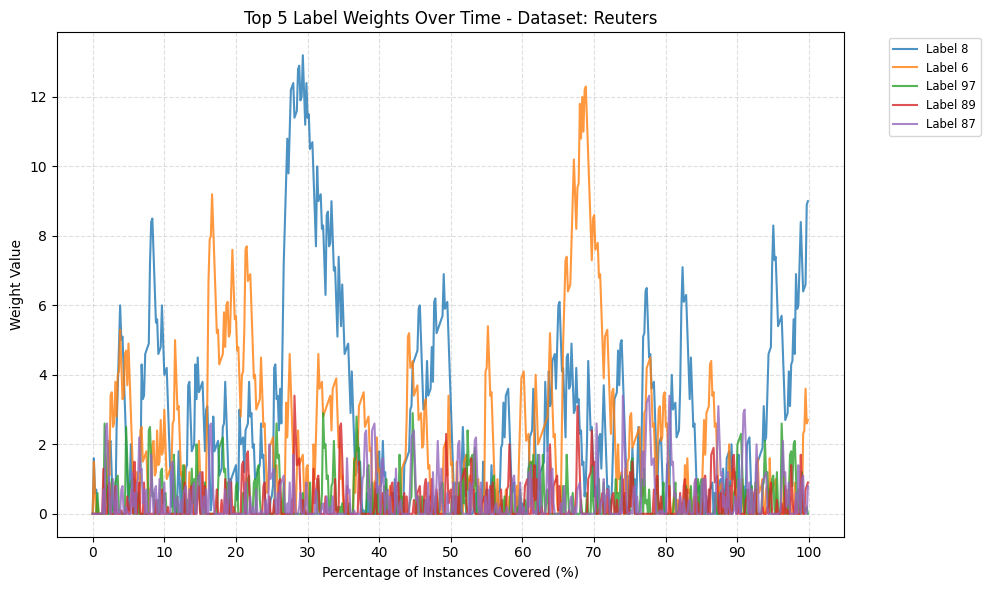

100%|██████████| 6000/6000 [00:34<00:00, 176.25it/s]

Reuters.arff processed in 34.04280066490173 seconds.


Acc: 0.040 , Hamming Score: 0.956 
Micro-F1: 0.065 , Example-based F1: 0.066 
Results appended to ./results/experiment_results.txt


100%|█████████▉| 4995/5000 [00:31<00:00, 148.51it/s]The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


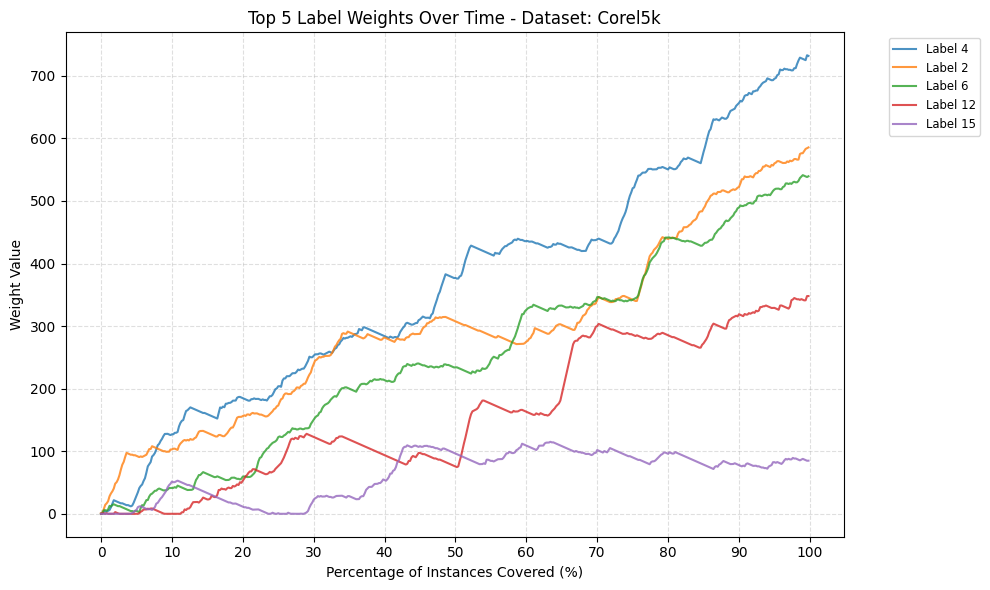

100%|██████████| 5000/5000 [00:32<00:00, 156.00it/s]

Corel5k.arff processed in 32.050684213638306 seconds.


Acc: 0.140 , Hamming Score: 0.916 
Micro-F1: 0.086 , Example-based F1: 0.248 
Results appended to ./results/experiment_results.txt


In [26]:
test_model_on_ds(WeightAdjustingBinaryTransformation, 'Reuters.arff', noise=False)
test_model_on_ds(WeightAdjustingBinaryTransformation, 'Corel5k.arff', noise=False)

CD = 1.0481349509868467
Average ranks: {'WABT': 1.3, 'CC': 2.3, 'PBT': 2.4}


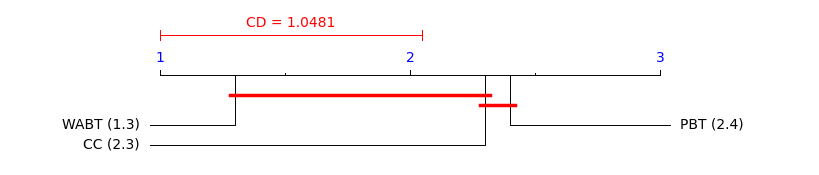

In [5]:
nemenyi.nemenyi_test_and_plot("./results/noisy_microf1.csv", ascending=False, save_plot=True)